In [1]:
from __future__ import print_function, division
import os
import pandas as pd
import numpy as np
import gurobipy as gb
import timeit
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def drop_duplicates_from_index(self,keep='first',inplace=False):
    """Return self with duplicate indices removed
    Parameters
    ----------
    keep : {'first_last', first', 'last', False}, default 'first'
        - ``first_last`` : Drop duplicates except for the first and the last occurence
        - otherwise default 'drop_duplicates' behaviour.
    """
    if keep=='first_last':
        result = self[np.logical_not(self.index.duplicated(keep='first')) | np.logical_not(self.index.duplicated(keep='last'))]
    else:
        result = self[np.logical_not(self.index.duplicated(keep=keep))]
    if inplace:
        return self._update_inplace(result)
    else:
        return result
pd.Series.drop_duplicates_from_index = drop_duplicates_from_index

In [3]:
# load graph
nodes = pd.read_csv("data/graph/nodes.csv",header=None,squeeze=True).values
edges = pd.read_csv("data/graph/edges.csv",header=None).values
# nodes = ['DK','DE','SE']
# edges = [('DK','DE'),('DE','SE'),('SE','DK')]
Nnodes = len(nodes)
Nlinks = len(edges)

In [4]:
# # create Cost-Balancing data for EU by random shifting exiting data
# df_DK = pd.read_csv("./DK.csv",index_col=0,sep=',')
# df_DK.columns = pd.to_numeric(df_DK.columns.values)
# index = df_DK.index
# for n,node in enumerate(nodes):
#     n = n+1
#     df = df_DK
#     df = pd.concat([df.iloc[-24*n:,:],df.shift(24*n).iloc[24*n:,:]])
#     df.index = index
#     df.to_csv('./data/cost_blancing/{}.csv'.format(node))

In [5]:
# load Cost-Balancing data from EnergyPLAN
CB = {}
for n in nodes:
    df = pd.read_csv("data/cost_blancing/{}.csv".format(n),index_col=0,sep=',')
    df.columns = pd.to_numeric(df.columns.values)
    CB[n] = df
T = CB[n].index.values

In [226]:
a=CB['AT'].loc[1]

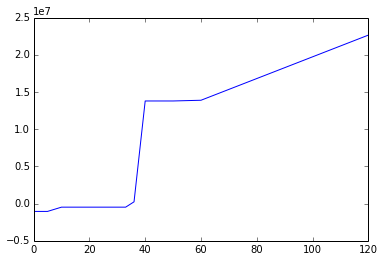

In [230]:
(a*a.abs()).plot()

In [7]:
#cb.sample(frac=1.,random_state=12345).reset_index(drop=True)

In [8]:
# d = pd.Series(np.ones(8784),index=CB['DK'].index.values)
# d.rename('Demand')
# d.to_csv('DE.csv')

In [9]:
# # load demand data from EnergyPLAN
# D = {}
# for n in nodes:
#     D[n] = pd.read_csv("data/demand/{}.csv".format(n),index_col=0)

In [103]:
from vresutils import timer

In [109]:
T = np.arange(600,700)
T = [626]
results = pd.DataFrame(index=T)
times=pd.DataFrame()
start_all = timeit.default_timer()

with timer('all'):
    for t in T:
        m = gb.Model()
        epsilon = 1.e-5
        Fl_b = 1000.01
        p = {}
        for n in nodes:
            p[n] = CB[n].columns.values.tolist()
    #         p[n] = [j*D[n].loc[t].values for j in p[n]]
        with timer('add_fl_Vars'):
            fl_p = [m.addVar(lb=0,ub=Fl_b,name='link {}-{} pos'.format(bus0,bus1)) for bus0,bus1 in edges]
            fl_n = [m.addVar(lb=0,ub=Fl_b,name='link {}-{} neg'.format(bus0,bus1)) for bus0,bus1 in edges]
            fl_t = [m.addVar(lb=-Fl_b,ub=Fl_b,name='link {}-{}'.format(bus0,bus1)) for bus0,bus1 in edges]
        with timer('update_fl_Vars'):
            m.update()
        with timer('addConstr_fl_Vars'):
            [m.addConstr(fltot - (flp-fln) == 0) for fltot,flp,fln in zip(fl_t,fl_p,fl_n)]
        with timer('addObj'):
            Obj = gb.LinExpr()
            Obj.addTerms(np.repeat(epsilon,2*len(edges)),fl_p+fl_n)
            #Obj = gb.QuadExpr()
            #Obj.addTerms(np.repeat(epsilon,Nlinks),fl_t,fl_t)
            m.setObjective(expr=Obj)
        
        with timer('define b'):
            b = {}
            lbs =[]
            for n in nodes:
                with timer('loop'):
                    with timer('extract'):
                        b[n] = CB[n].loc[t,:].values.tolist()
                    with timer('append lb'):
                        lbs.append(b[n][0])
                    with timer('definde a'):
                        a = pd.Series(index=b[n],data=p[n])
                    with timer('drop index'):
                        a = a.drop_duplicates_from_index(keep='first_last')
                    with timer('sort'):
                        a.sort_index(inplace=True)
                    with timer('shift x'):
                        a.index=a.index+a.index.duplicated(keep='first')*1e-3
                    with timer('set b,p'):
                        b[n] = a.index.values
                        p[n] = a.values
        with timer('add_B_Vars'):
            B = [m.addVar(lb=lb, name='B {}'.format(node)) for node,lb in zip(nodes,lbs)]
            m.update()
        with timer('setPWLObj'):
            [m.setPWLObj(B[nn],b[node],p[node]) for nn,node in enumerate(nodes)]

        # Nodal energy balance constraint
        # B = sum_l K_nl*fl
        # B = P + C
        with timer('add P,C'):
            P = [m.addVar(lb=-gb.GRB.INFINITY, name='P {}'.format(node)) for node in nodes]
            C = [m.addVar(lb=0., name='C {}'.format(node)) for node in nodes]
            m.update()
        
        with timer('add Balance constraint'):
            for nn,node in enumerate(nodes):
                m.addConstr(P[nn] - (
                    gb.quicksum([fl_t[ll] for ll,edge in enumerate(edges) if edge[0]==node]) +
                    gb.quicksum([-fl_t[ll] for ll,edge in enumerate(edges) if edge[1]==node])
                    ) == 0 ,'balance-{}'.format(node)) 
                m.addConstr(B[nn]-P[nn]-C[nn] == 0) 
        m.setParam('OutputFlag', 0)
        with timer('optimize'):
            m.optimize()
        status = m.status
        with timer('extract results'):
            if status == gb.GRB.OPTIMAL:
                d = {}
                for v in m.getVars():
                    d[v.VarName] = v.X
                df = pd.DataFrame([d],columns=d.keys().sort())
                results = pd.concat([results,df])
                times.at[t,'all'] = timeit.default_timer() - start
            else:
                times.at[t,'all'] = np.nan
    stop = timeit.default_timer()
    print(stop - start_all)

all: 
.. add_fl_Vars: 1.1 msec
.. update_fl_Vars: 114.9 usec
.. addConstr_fl_Vars: 2.6 msec
.. addObj: 191.9 usec
.. define b: 
.. .. loop: 
.. .. .. extract: 381.9 usec
.. .. .. append lb: 5.0 usec
.. .. .. definde a: 287.1 usec
.. .. .. drop index: 345.0 usec
.. .. .. sort: 47.0 usec
.. .. .. shift x: 258.0 usec
.. .. .. set b,p: 11.9 usec
.. .. .. 11.0 msec
.. .. loop: 
.. .. .. extract: 355.0 usec
.. .. .. append lb: 2.9 usec
.. .. .. definde a: 339.0 usec
.. .. .. drop index: 344.0 usec
.. .. .. sort: 52.9 usec
.. .. .. shift x: 266.8 usec
.. .. .. set b,p: 16.9 usec
.. .. .. 11.0 msec
.. .. loop: 
.. .. .. extract: 345.0 usec
.. .. .. append lb: 3.8 usec
.. .. .. definde a: 351.0 usec
.. .. .. drop index: 355.0 usec
.. .. .. sort: 67.9 usec
.. .. .. shift x: 261.1 usec
.. .. .. set b,p: 16.9 usec
.. .. .. 11.7 msec
.. .. loop: 
.. .. .. extract: 332.1 usec
.. .. .. append lb: 2.9 usec
.. .. .. definde a: 268.0 usec
.. .. .. drop index: 336.9 usec
.. .. .. sort: 48.9 usec
.. .. ..

In [201]:
T = np.arange(1000,2000)
#T = [626]
results = []#pd.DataFrame()
times=pd.DataFrame()
start_all = timeit.default_timer()

for t in T:
    start = timeit.default_timer()

    m = gb.Model()
    epsilon = 1.e-5
    Fl_b = 1000.01
    p = {}
    for n in nodes:
        p[n] = CB[n].columns.values.tolist()
#         p[n] = [j*D[n].loc[t].values for j in p[n]]
    fl_p = [m.addVar(lb=0,ub=Fl_b,name='link {}-{} pos'.format(bus0,bus1)) for bus0,bus1 in edges]
    fl_n = [m.addVar(lb=0,ub=Fl_b,name='link {}-{} neg'.format(bus0,bus1)) for bus0,bus1 in edges]
    fl_t = [m.addVar(lb=-Fl_b,ub=Fl_b,name='link {}-{}'.format(bus0,bus1)) for bus0,bus1 in edges]
    m.update()
    [m.addConstr(fltot - (flp-fln) == 0) for fltot,flp,fln in zip(fl_t,fl_p,fl_n)]
    Obj = gb.LinExpr()
    Obj.addTerms(np.repeat(epsilon,2*len(edges)),fl_p+fl_n)
    #Obj = gb.QuadExpr()
    #Obj.addTerms(np.repeat(epsilon,Nlinks),fl_t,fl_t)
    m.setObjective(expr=Obj)

    b = {}
    lbs =[]
    for n in nodes:
        b[n] = CB[n].loc[t,:].values.tolist()
        lbs.append(b[n][0])
        a = pd.Series(index=b[n],data=p[n])
        a = a.drop_duplicates_from_index(keep='first_last')
        a.sort_index(inplace=True)
        a.index=a.index+a.index.duplicated(keep='first')*1e-3
        b[n] = a.index.values
        p[n] = a.values
    B = [m.addVar(lb=lb, name='B {}'.format(node)) for node,lb in zip(nodes,lbs)]
    m.update()
    [m.setPWLObj(B[nn],b[node],p[node]) for nn,node in enumerate(nodes)]

    # Nodal energy balance constraint
    # B = sum_l K_nl*fl
    # B = P + C
    P = [m.addVar(lb=-gb.GRB.INFINITY, name='P {}'.format(node)) for node in nodes]
    C = [m.addVar(lb=0., name='C {}'.format(node)) for node in nodes]
    m.update()
    
    for nn,node in enumerate(nodes):
        m.addConstr(P[nn] - (
            gb.quicksum([fl_t[ll] for ll,edge in enumerate(edges) if edge[0]==node]) +
            gb.quicksum([-fl_t[ll] for ll,edge in enumerate(edges) if edge[1]==node])
            ) == 0 ,'balance-{}'.format(node)) 
        m.addConstr(B[nn]-P[nn]-C[nn] == 0) 
    m.setParam('OutputFlag', 0)
    m.optimize()
    status = m.status
    if status == gb.GRB.OPTIMAL:
        d = {}
        for v in m.getVars():
            d[v.VarName] = v.X
        results.append(pd.Series(d,name=t))
        times.at[t,'all'] = timeit.default_timer() - start
    else:
        times.at[t,'all'] = np.nan
stop = timeit.default_timer()
print(stop - start_all)

102.837901831


In [202]:
results_lin = pd.concat(results,axis=1).T
times_lin = times.copy().squeeze().rename('Linear')

In [203]:
T = np.arange(1000,2000)
#T = [626]
results = []#pd.DataFrame()
times=pd.DataFrame()
start_all = timeit.default_timer()

for t in T:
    start = timeit.default_timer()

    m = gb.Model()
    epsilon = 1.e-5
    Fl_b = 1000.01
    p = {}
    for n in nodes:
        p[n] = CB[n].columns.values.tolist()
#         p[n] = [j*D[n].loc[t].values for j in p[n]]
    #fl_p = [m.addVar(lb=0,ub=Fl_b,name='link {}-{} pos'.format(bus0,bus1)) for bus0,bus1 in edges]
    #fl_n = [m.addVar(lb=0,ub=Fl_b,name='link {}-{} neg'.format(bus0,bus1)) for bus0,bus1 in edges]
    fl_t = [m.addVar(lb=-Fl_b,ub=Fl_b,name='link {}-{}'.format(bus0,bus1)) for bus0,bus1 in edges]
    m.update()
    #[m.addConstr(fltot - (flp-fln) == 0) for fltot,flp,fln in zip(fl_t,fl_p,fl_n)]
    #Obj = gb.LinExpr()
    #Obj.addTerms(np.repeat(epsilon,2*len(edges)),fl_p+fl_n)
    Obj = gb.QuadExpr()
    Obj.addTerms(np.repeat(epsilon,Nlinks),fl_t,fl_t)
    m.setObjective(expr=Obj)

    b = {}
    lbs =[]
    for n in nodes:
        b[n] = CB[n].loc[t,:].values.tolist()
        lbs.append(b[n][0])
        a = pd.Series(index=b[n],data=p[n])
        a = a.drop_duplicates_from_index(keep='first_last')
        a.sort_index(inplace=True)
        a.index=a.index+a.index.duplicated(keep='first')*1e-3
        b[n] = a.index.values
        p[n] = a.values
    B = [m.addVar(lb=lb, name='B {}'.format(node)) for node,lb in zip(nodes,lbs)]
    m.update()
    [m.setPWLObj(B[nn],b[node],p[node]) for nn,node in enumerate(nodes) if ]

    # Nodal energy balance constraint
    # B = sum_l K_nl*fl
    # B = P + C
    P = [m.addVar(lb=-gb.GRB.INFINITY, name='P {}'.format(node)) for node in nodes]
    C = [m.addVar(lb=0., name='C {}'.format(node)) for node in nodes]
    m.update()
    
    for nn,node in enumerate(nodes):
        m.addConstr(P[nn] - (
            gb.quicksum([fl_t[ll] for ll,edge in enumerate(edges) if edge[0]==node]) +
            gb.quicksum([-fl_t[ll] for ll,edge in enumerate(edges) if edge[1]==node])
            ) == 0 ,'balance-{}'.format(node)) 
        m.addConstr(B[nn]-P[nn]-C[nn] == 0) 
    m.setParam('OutputFlag', 0)
    m.optimize()
    status = m.status
    if status == gb.GRB.OPTIMAL:
        d = {}
        for v in m.getVars():
            d[v.VarName] = v.X
        results.append(pd.Series(d,name=t))
        times.at[t,'all'] = timeit.default_timer() - start
    else:
        times.at[t,'all'] = np.nan
stop = timeit.default_timer()
print(stop - start_all)

145.041074038


In [204]:
results_quad = pd.concat(results,axis=1).T
times_quad = times.copy().squeeze().rename('Quadratic')

Saved: optimization_time_per_timestep.eps


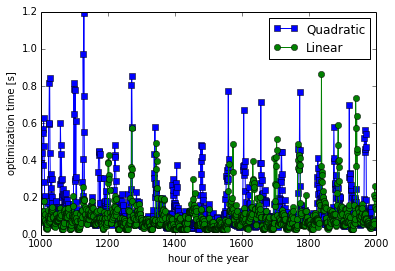

In [215]:
fig,ax=plt.subplots(1,1)
times_quad.plot(ax=ax,marker='s')
times_lin.plot(ax=ax,marker='o')
ax.legend(loc=0)
ax.set_xlabel('hour of the year')
ax.set_ylabel('optimization time [s]')
if True:
    plotname='optimization_time_per_timestep.eps'
    print('Saved: {}'.format(plotname))
    fig.savefig(plotname)

Saved: optimization_time_per_timestep_sorted.eps


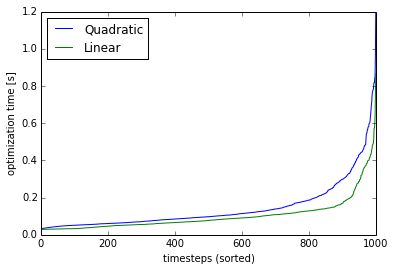

In [216]:
fig,ax=plt.subplots(1,1)
times_quad.sort_values().reset_index(drop=True).plot(ax=ax)#,marker='s')
times_lin.sort_values().reset_index(drop=True).plot(ax=ax)#,marker='o')
ax.legend(loc='upper left')
ax.set_xlabel('timesteps (sorted)')
ax.set_ylabel('optimization time [s]')
if True:
    plotname='optimization_time_per_timestep_sorted.eps'
    print('Saved: {}'.format(plotname))
    fig.savefig(plotname)

Saved: cumulative_optimization_time_per_timestep.eps


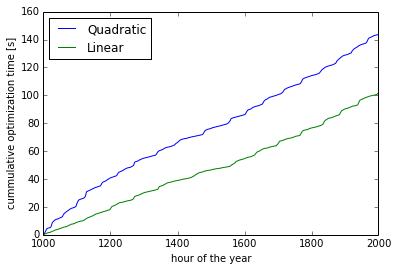

In [217]:
fig,ax=plt.subplots(1,1)
times_quad.cumsum().plot(ax=ax)#,marker='s'
times_lin.cumsum().plot(ax=ax)#,marker='o'
ax.legend(loc=0)
ax.set_xlabel('hour of the year')
ax.set_ylabel('cummulative optimization time [s]')
if True:
    plotname='cumulative_optimization_time_per_timestep.eps'
    print('Saved: {}'.format(plotname))
    fig.savefig(plotname)

In [220]:
times_lin.isna().sum()

0